# Content-based recommendation

In [ ]:
import pandas as pd
import numpy as np
import scipy
import sklearn

In [33]:
from IPython.display import Image

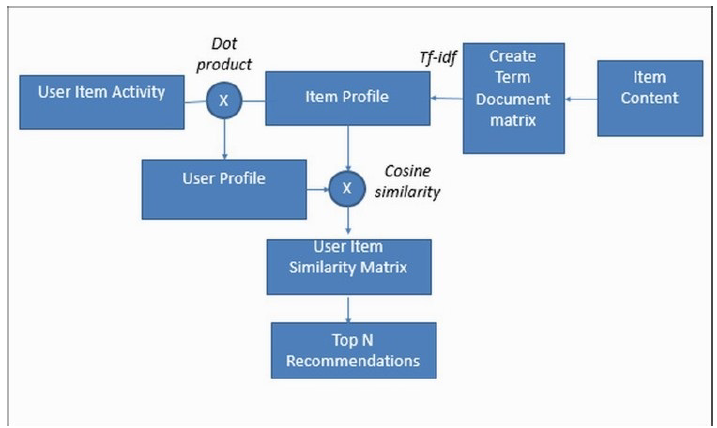

In [34]:
Image(filename='scheme.png')

In [2]:
raw_data = pd.read_csv('anonymous-msweb.test',header=None,skiprows=7)

In [3]:
#creating user profile
user_activity = raw_data.loc[raw_data[0] != "A"]
user_activity.columns = ['category','value','vote','desc','url']
user_activity = user_activity[['category','value']]

In [4]:
user_activity.groupby('category').count()
len(user_activity.loc[user_activity['category'] =="C"].value.unique())

5000

In [5]:
len(user_activity.loc[user_activity['category'] =="V"].value.unique())

236

In [6]:
nextrow = False
print(user_activity.index)
lastindex = user_activity.index[len(user_activity)-1]

Int64Index([  294,   295,   296,   297,   298,   299,   300,   301,   302,
              303,
            ...
            20475, 20476, 20477, 20478, 20479, 20480, 20481, 20482, 20483,
            20484],
           dtype='int64', length=20191)


In [7]:
for index,row in user_activity.iterrows():
    if(index <= lastindex ):
        if(user_activity.loc[index,'category'] == "C"):
            tmp = 0
            #add += 1
            #user_activity.loc[index,'chunk'] += add
            userid = user_activity.loc[index,'value']
            user_activity.loc[index,'userid'] = userid
            user_activity.loc[index,'webid'] = userid
            tmp = userid
            nextrow = True            
        elif(user_activity.loc[index,'category'] != "C" and nextrow == True):
                #user_activity.loc[index,'chunk'] += add
                webid = user_activity.loc[index,'value']
                user_activity.loc[index,'webid'] = webid
                user_activity.loc[index,'userid'] = tmp
                if(index != lastindex and user_activity.loc[index+1,'category'] == "C"):
                    nextrow = False
                    caseid = 0

In [8]:
user_activity = user_activity[user_activity['category'] == "V" ]
user_activity = user_activity[['userid','webid']]
user_activity_sort = user_activity.sort_values('webid', ascending=True)

In [9]:
user_activity['userid'].unique().shape[0]
user_activity['webid'].unique().shape[0]

236

In [10]:
sLength = len(user_activity_sort['webid'])
user_activity_sort['rating'] = pd.Series(np.ones((sLength,)), index=user_activity.index)
ratmat = user_activity_sort.pivot(index='userid', columns='webid', values='rating').fillna(0)
ratmat = ratmat.to_dense().as_matrix()


In [13]:
ratmat.shape

(5000, 236)

In [14]:
#creating item profile

In [16]:
items = raw_data.loc[raw_data[0] == "A"]
items.columns = ['record','webid','vote','desc','url']
items = items[['webid','desc']]
items['webid'].unique().shape[0]
items2 = items[items['webid'].isin(user_activity['webid'].tolist())]
items_sort = items2.sort_values('webid', ascending=True)

In [17]:
#tfidf

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
v = TfidfVectorizer(stop_words ="english",max_features = 100,ngram_range= (0,3),sublinear_tf =True)
x = v.fit_transform(items_sort['desc'])
itemprof = x.todense()

In [20]:
itemprof.shape

(236, 100)

In [21]:
#dot product

In [22]:
from scipy import linalg, dot
userprof = dot(ratmat,itemprof)/linalg.norm(ratmat)/linalg.norm(itemprof)

In [23]:
#cosine similarity between  userprofile an item profile

In [24]:
import sklearn.metrics

In [25]:
similarityCalc = sklearn.metrics.pairwise.cosine_similarity(userprof, itemprof, dense_output=True)

In [26]:
#covert the rating to binary format

In [27]:
final_pred= np.where(similarityCalc>0.6, 1, 0)

In [ ]:
# Generate recommended items for user 213 

In [28]:
indexes_of_user = np.where(final_pred[213] == 1)

In [29]:
indexes_of_user

(array([  9,  37,  68, 152], dtype=int64),)